In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

import polars as pl
import numpy as np

from adex.models import Condition, ConditionDataLoader, ConditionSequencingTissueDataLoader, \
    ConditionSequencingDataLoader, SequencingTechnique, TissueEnum, METADATA_COLUMNS, FileDataLoader, DataLoader
from adex.helpers import get_pre_processed_dataset, run_ml_model
from adex.models import DATASET_INFO_COLUMNS
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

data_path = "../data/adex-database/samples"
metadata_path = "../data/adex-database/metadata.csv"
datasets_info_path = "../data/adex-database/datasets_info.csv"
results_path = "../results"

# Prepare Data

In [56]:
top_de_genes_ra_GSE89408 = (
    pl
    .read_csv(f"../results/GSE89408_only_train_samples/edgeR_de_genes.csv", has_header=True)
    .to_series()
    .to_list()
)
len(top_de_genes_ra_GSE89408)

148

In [57]:
de_GSE89408 = (
    get_pre_processed_dataset(
        data_loader=FileDataLoader(
            condition=Condition.RA,
            file_name="GSE89408.tsv.parquet",
            genes=top_de_genes_ra_GSE89408
        ),
        data_path=data_path,
        metadata_path=metadata_path,
        datasets_info_path=datasets_info_path,
        return_metadata=True
    ).fill_null(value=0)
    .drop(filter(lambda item: item != 'Condition',METADATA_COLUMNS)) # We need only the condition from Metadata  
    .drop(DATASET_INFO_COLUMNS)
    .with_columns(
        pl.col("Condition")
            .map_elements(lambda x: 0 if x == "Healthy" else 1, return_dtype=pl.Int8)
            .alias("class_label")
    )
    .drop("Condition")
).sort("Sample")  # Remove randomness at this point 
de_GSE89408

Sample,VDAC2P2,AC103591.3,FCGR1CP,HORMAD1,GOLGA5P1,AC112496.1,DM1-AS,C12orf74,AC084876.1,HIST1H2AK,AC091185.2,CCL4,AC008833.1,AC006272.1,AC011472.3,SERPINI2,THSD8,AC006027.1,AC090617.3,AC068831.4,AC133065.1,AC073896.1,NME8,AC008993.2,B3GALNT1P1,AC022973.1,AC129492.4,C4orf45,MTND1P23,AL157402.2,RNVU1-14,NTN3,UBE2FP1,AC096667.1,SNRPGP10,AC012181.2,…,LINC02605,AC013444.2,AL139011.2,NYAP1,AC068631.2,AC015911.3,AC023825.1,AC025259.1,E2F7,RPL36A-HNRNPH2,TRGV10,AL512504.1,AC068547.1,AC022973.3,SCG5,CDC45,AC022079.1,AL136295.1,FOXI2,AP000462.1,AC006460.1,AC133555.4,SHOX,AC017083.2,LINC00671,AL359095.1,HAUS1P1,AC020909.4,TOMM20P2,RPL39P3,AC006486.1,MOXD1,STEAP1B,AC124068.1,SPATA20P1,AP003696.1,class_label
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8
"""GSM2370970""",3.05567,0.0,4.594747,2.826927,2.826927,1.781672,6.622488,0.0,0.0,1.781672,1.149989,5.895251,3.721507,0.0,0.0,3.05567,0.0,0.0,0.0,0.0,2.554955,8.464858,1.781672,1.149989,0.0,3.05567,7.83135,0.0,5.184064,1.781672,0.0,6.912578,1.149989,1.781672,0.0,3.721507,…,4.798087,3.05567,8.839742,5.23165,5.322358,3.05567,1.149989,0.0,4.73344,8.155099,2.554955,0.0,3.721507,1.149989,3.849033,4.269545,1.149989,0.0,5.488271,3.05567,2.219515,5.448547,6.822211,0.0,4.269545,0.0,2.219515,0.0,1.781672,3.849033,0.0,1.149989,3.721507,0.0,0.0,0.0,0
"""GSM2370971""",3.530425,2.813799,0.0,4.364701,1.326442,3.094096,4.364701,2.813799,3.530425,2.00564,3.530425,2.465583,7.577331,2.813799,6.197237,3.864979,4.814602,4.96147,5.707811,7.769032,1.326442,3.530425,1.326442,7.947064,5.274107,2.465583,0.0,3.328693,5.865367,2.465583,2.813799,2.813799,3.530425,0.0,3.707378,4.255048,…,4.466606,1.326442,2.00564,2.465583,1.326442,0.0,3.094096,6.073492,1.326442,3.328693,1.326442,2.465583,7.55437,4.13637,0.0,0.0,3.707378,0.0,3.094096,5.622072,2.813799,0.0,4.13637,7.938222,4.007047,4.466606,3.094096,5.274107,1.326442,8.262519,4.007047,5.274107,6.515227,5.329256,0.0,5.029652,0
"""GSM2370972""",2.90839,3.314439,3.191365,3.427834,0.858757,3.722698,3.808962,3.808962,5.590409,3.427834,3.056805,3.532962,3.056805,2.341239,4.840874,2.088786,2.556025,6.046098,2.742939,5.26378,3.056805,5.381067,2.088786,7.657699,4.110154,4.30085,0.0,3.532962,4.756554,2.90839,3.808962,3.890357,4.521291,2.556025,3.314439,5.46317,…,2.556025,3.427834,5.489532,3.191365,2.341239,4.469258,2.90839,0.0,0.0,5.408957,0.858757,3.722698,5.408957,3.056805,2.088786,1.393389,3.427834,0.0,3.314439,2.556025,4.521291,0.858757,5.26378,7.53651,4.415277,4.040544,2.088786,3.808962,3.532962,5.294008,2.341239,2.088786,1.782587,4.620045,0.0,4.521291,0
"""GSM2370973""",1.676383,1.069102,4.988574,3.709225,3.58271,2.102451,4.714627,3.933163,4.588606,3.11884,3.290575,5.131011,3.290575,2.923865,5.131011,3.709225,2.430957,3.709225,0.0,0.0,3.11884,7.353349,2.69836,6.282976,3.290575,3.933163,6.672818,3.58271,4.652992,1.676383,3.444024,4.773736,4.033316,3.709225,3.290575,2.102451,…,4.937789,4.297791,6.362144,3.709225,0.0,1.676383,3.290575,0.0,2.69836,7.232137,0.0,2.923865,4.714627,3.11884,2.923865,2.923865,3.933163,0.0,3.11884,4.126966,3.933163,2.430957,0.0,0.0,3.11884,3.11884,2.69836,0.0,2.69836,3.825534,0.0,5.175528,1.069102,0.0,6.875307,4.521211,0
"""GSM2370974""",3.761456,3.126018,1.552158,2.956789,2.282472,1.963042,4.652884,3.539662,4.810225,2.543839,3.277464,4.040931,3.277464,0.0,4.810225,4.123229,4.123229,5.758763,3.414511,3.539662,2.282472,5.706329,0.975467,7.466484,3.860753,2.956789,6.326155,3.654817,4.952082,1.552158,0.975467,4.201084,2.956789,2.543839,3.277464,4.537568,…,2.765039,1.963042,6.758314,6.01735,1.963042,4.040931,3.414511,0.0,0.975467,6.535996,0.0,3.126018,3.860753,3.277464,1.963042,2.765039,3.860753,5.161323,4.476259,3.277464,2.956789,2.543839,7.29067,5.758763,6.059763,3.414511,1.552158,3.860753,1.963042,3.414511,

In [58]:
de_GSE89408.select(pl.col("class_label").value_counts()) # Imbalanced data between the two classes

class_label
struct[2]
"{0,28}"
"{1,152}"


In [59]:
x_df = (
        de_GSE89408.select([
            pl.all().exclude("Sample", "class_label"),
        ]).to_pandas()
 )
x_df

,VDAC2P2,AC103591.3,FCGR1CP,HORMAD1,GOLGA5P1,AC112496.1,DM1-AS,C12orf74,AC084876.1,HIST1H2AK,...,HAUS1P1,AC020909.4,TOMM20P2,RPL39P3,AC006486.1,MOXD1,STEAP1B,AC124068.1,SPATA20P1,AP003696.1
0,3.055670,0.000000,4.594747,2.826927,2.826927,1.781672,6.622488,0.000000,0.000000,1.781672,...,2.219515,0.000000,1.781672,3.849033,0.000000,1.149989,3.721507,0.000000,0.000000,0.000000
1,3.530425,2.813799,0.000000,4.364701,1.326442,3.094096,4.364701,2.813799,3.530425,2.005640,...,3.094096,5.274107,1.326442,8.262519,4.007047,5.274107,6.515227,5.329256,0.000000,5.029652
2,2.908390,3.314439,3.191365,3.427834,0.858757,3.722698,3.808962,3.808962,5.590409,3.427834,...,2.088786,3.808962,3.532962,5.294008,2.341239,2.088786,1.782587,4.620045,0.000000,4.521291
3,1.676383,1.069102,4.988574,3.709225,3.582710,2.102451,4.714627,3.933163,4.588606,3.118840,...,2.698360,0.000000,2.698360,3.825534,0.000000,5.175528,1.069102,0.000000,6.875307,4.521211
4,3.761456,3.126018,1.552158,2.956789,2.282472,1.963042,4.652884,3.539662,4.810225,2.543839,...,1.552158,3.860753,1.963042,3.414511,3.953653,1.552158,1.963042,0.000000,0.000000,4.537568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,4.297458,5.697685,6.409159,4.527134,5.161171,3.110216,3.110216,4.899359,5.353052,6.069768,...,3.865280,4.979133,2.390044,7.113036,3.588386,5.322792,4.167273,6.409159,3.588386,4.579263
176,2.288607,5.344672,6.534589,5.501395,5.525936,0.829580,1.736174,3.747892,3.255327,4.735877,...,3.661924,7.544912,2.038673,8.344648,5.963389,5.344672,3.368213,7.073317,4.968532,4.735877
177,4.226978,5.515299,6.150971,3.772043,5.047704,3.772043,3.238939,3.680031,4.892361,5.433126,...,3.362483,6.416332,2.954717,6.565217,5.908980,6.790941,2.788414,5.488424,3.680031,5.220960
178,3.075558,3.687983,4.714933,3.197420,4.116559,2.795792,2.448396,4.586973,5.042191,4.446549,...,3.987348,6.813169,3.075558,7.113302,5.510358,7.853838,4.290968,8.600325,5.225265,4.832463


In [60]:
y_df = de_GSE89408.select(pl.col("class_label").alias("y")).to_pandas()
y_df

,y
0,0
1,0
2,0
3,0
4,0
...,...
175,1
176,1
177,1
178,1


In [61]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x_df, y_df, 
    train_size=0.7, 
    random_state=42,  # Ensure a reproducible split 
    shuffle=True, 
    stratify=y_df  # solve the class imbalance issue 
)

In [62]:
x_train

,VDAC2P2,AC103591.3,FCGR1CP,HORMAD1,GOLGA5P1,AC112496.1,DM1-AS,C12orf74,AC084876.1,HIST1H2AK,...,HAUS1P1,AC020909.4,TOMM20P2,RPL39P3,AC006486.1,MOXD1,STEAP1B,AC124068.1,SPATA20P1,AP003696.1
13,3.157536,0.000000,5.069209,1.864341,3.157536,0.910992,5.520336,2.433411,1.864341,1.864341,...,3.007681,0.000000,3.531576,4.348193,0.000000,4.524093,0.000000,0.000000,0.910992,2.433411
73,4.458526,4.458526,7.604703,5.103796,5.219125,4.458526,2.749214,4.841148,5.688114,5.740535,...,4.023493,6.487267,4.635054,6.909769,6.254736,7.316058,5.291187,7.375281,5.887257,5.714563
4,3.761456,3.126018,1.552158,2.956789,2.282472,1.963042,4.652884,3.539662,4.810225,2.543839,...,1.552158,3.860753,1.963042,3.414511,3.953653,1.552158,1.963042,0.000000,0.000000,4.537568
5,5.282779,2.614842,6.205216,5.079104,6.164560,2.838079,2.350624,4.789359,4.988837,0.000000,...,3.840610,3.617796,4.789359,4.789359,3.354171,6.057605,1.608915,0.000000,3.617796,4.941494
57,5.833254,4.644211,7.822674,4.087811,5.899217,3.369568,2.322224,5.209813,5.209813,5.899217,...,5.044753,5.534341,5.260888,7.180277,0.000000,6.108889,4.087811,7.126211,6.768551,4.790434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,4.103822,4.177402,7.681046,4.806828,5.342875,4.806828,3.321436,3.321436,5.804240,5.277452,...,3.666253,6.189286,3.185380,7.124613,4.314178,5.277452,2.867425,6.681751,5.708203,5.849962
64,2.832766,2.643735,6.666969,4.813642,5.060556,4.459294,2.169813,5.022228,5.366181,5.169785,...,4.275987,5.764730,2.169813,7.259600,2.169813,5.693345,2.999874,6.874838,5.565913,5.483675
176,2.288607,5.344672,6.534589,5.501395,5.525936,0.829580,1.736174,3.747892,3.255327,4.735877,...,3.661924,7.544912,2.038673,8.344648,5.963389,5.344672,3.368213,7.073317,4.968532,4.735877
89,3.020812,2.663841,7.539331,5.615729,6.118813,5.856237,2.188439,4.791080,5.878221,4.161974,...,5.788198,6.062321,5.389511,6.402856,5.358567,7.108395,3.842270,4.298668,5.419806,5.083750


In [63]:
y_train

,y
13,0
73,1
4,0
5,0
57,1
...,...
53,1
64,1
176,1
89,1


In [64]:
y_train.value_counts()

y
1    106
0     19
Name: count, dtype: int64

In [65]:
x_test

,VDAC2P2,AC103591.3,FCGR1CP,HORMAD1,GOLGA5P1,AC112496.1,DM1-AS,C12orf74,AC084876.1,HIST1H2AK,...,HAUS1P1,AC020909.4,TOMM20P2,RPL39P3,AC006486.1,MOXD1,STEAP1B,AC124068.1,SPATA20P1,AP003696.1
18,3.920056,3.920056,4.602012,5.383680,4.650588,2.936015,4.070454,3.997214,5.782807,3.997214,...,3.562064,5.412135,3.219739,5.520654,3.660228,1.805233,3.219739,5.846745,3.562064,4.989588
98,4.946210,4.360579,3.944872,6.684112,6.982845,6.127530,3.845145,4.208353,6.325545,4.682909,...,5.168794,2.618922,5.922620,6.847654,4.794059,4.946210,5.325031,6.466455,7.210303,5.683711
166,4.151664,6.870580,1.924328,3.904773,4.362414,6.476729,1.924328,5.275775,5.965858,4.546265,...,4.151664,5.757994,4.151664,8.043227,5.222758,5.681472,3.230634,6.334043,3.230634,5.757994
140,3.215723,4.135911,2.038738,4.218538,4.749918,1.619447,1.619447,4.441332,3.632169,4.956628,...,4.441332,6.590038,0.000000,7.987854,3.632169,6.298685,1.025940,0.000000,6.694773,1.619447
29,4.109637,3.326994,6.973673,6.065158,6.455124,4.559977,2.206040,3.770749,6.425101,6.159354,...,6.963265,5.471475,3.040566,7.158380,5.689215,7.837227,4.559977,2.206040,5.557024,5.249605
90,1.850073,3.275595,5.928826,5.193937,5.123807,4.055812,2.634679,3.619311,6.102969,5.324730,...,5.730740,5.528463,2.990439,6.413362,4.199114,6.831514,4.448998,7.073957,6.579769,5.473129
162,2.024394,7.012320,6.790361,5.578642,5.020108,3.238416,0.821345,2.671150,5.406701,5.668414,...,2.835200,7.111682,0.000000,7.333727,6.191857,5.241020,2.835200,4.717689,3.961067,4.490407
105,5.045513,5.286527,6.756031,5.088583,6.376180,3.586021,3.701505,4.460533,5.931873,4.249021,...,5.249051,5.524691,5.171047,6.756031,4.955313,6.742611,4.001082,6.210592,6.323068,4.908006
74,3.933736,0.000000,8.194180,4.166680,4.649640,0.000000,3.754515,0.920376,3.846907,6.935398,...,3.846907,4.649640,4.649640,7.892034,0.000000,6.744435,4.093133,0.000000,6.914200,3.655799
45,3.737057,2.353716,6.958167,6.061393,6.147585,2.353716,2.353716,3.737057,4.430082,5.396225,...,4.681919,4.124789,3.737057,7.800998,5.248023,5.082836,4.896259,6.378994,5.082836,3.737057


In [66]:
y_test

,y
18,0
98,1
166,1
140,1
29,1
90,1
162,1
105,1
74,1
45,1


In [67]:
y_test.value_counts()

y
1    46
0     9
Name: count, dtype: int64

## Univariate Feature Selection

In [68]:
selector = SelectKBest(f_classif, k=10)
x_train_top_univariate_selection = selector.fit_transform(x_train, np.ravel(y_train))
x_train_top_univariate_selection

array([[3.15753627, 4.40924048, 0.91099235, ..., 1.46502204, 0.        ,
        4.34819315],
       [5.21912468, 5.10379619, 6.72698013, ..., 4.57857781, 6.48726662,
        6.90976947],
       [2.28247232, 2.95678932, 3.65481689, ..., 3.12601789, 3.86075266,
        3.41451093],
       ...,
       [5.52593635, 5.28840483, 4.50847405, ..., 4.29660736, 7.54491233,
        8.34464761],
       [6.11881261, 4.96550822, 7.78603378, ..., 4.6448548 , 6.06232081,
        6.40285555],
       [5.79589791, 6.01088184, 6.66087401, ..., 3.3114328 , 5.19810374,
        7.95416497]])

In [69]:
selected_genes = list(selector.get_feature_names_out())  
selected_genes

['GOLGA5P1',
 'AC022973.1',
 'TCTEX1D1',
 'AC090229.1',
 'HOXC-AS1',
 'AC025423.4',
 'AL359885.1',
 'AL512504.1',
 'AC020909.4',
 'RPL39P3']

In [70]:
top_10_de_genes = (
    pl
    .read_csv(f"../data/ml/GSE89408_top_de_train_genes.csv", has_header=True)
    .to_series()
    .to_list()
)
top_10_de_genes

['HOXC-AS1',
 'U62317.1',
 'AL139099.1',
 'AC025259.1',
 'AC020909.4',
 'AC211429.1',
 'AC068631.2',
 'HSPE1-MOB4',
 'AC025423.4',
 'AC017083.2']

In [71]:
common_genes = list(set(selected_genes).intersection(top_10_de_genes))
common_genes

['HOXC-AS1', 'AC025423.4', 'AC020909.4']

In [72]:
not_common_genes = list(set(selected_genes).difference(top_10_de_genes))
not_common_genes

['AL512504.1',
 'RPL39P3',
 'GOLGA5P1',
 'AC022973.1',
 'TCTEX1D1',
 'AC090229.1',
 'AL359885.1']

In [73]:
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

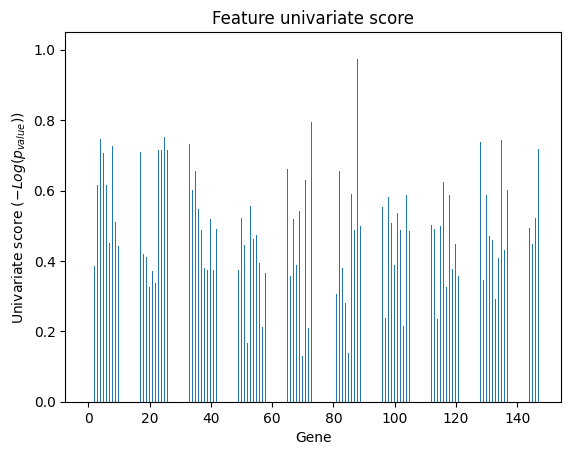

In [81]:
import matplotlib.pyplot as plt

X_indices = np.arange(x_train.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Gene")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

In [75]:
x_test

,VDAC2P2,AC103591.3,FCGR1CP,HORMAD1,GOLGA5P1,AC112496.1,DM1-AS,C12orf74,AC084876.1,HIST1H2AK,...,HAUS1P1,AC020909.4,TOMM20P2,RPL39P3,AC006486.1,MOXD1,STEAP1B,AC124068.1,SPATA20P1,AP003696.1
18,3.920056,3.920056,4.602012,5.383680,4.650588,2.936015,4.070454,3.997214,5.782807,3.997214,...,3.562064,5.412135,3.219739,5.520654,3.660228,1.805233,3.219739,5.846745,3.562064,4.989588
98,4.946210,4.360579,3.944872,6.684112,6.982845,6.127530,3.845145,4.208353,6.325545,4.682909,...,5.168794,2.618922,5.922620,6.847654,4.794059,4.946210,5.325031,6.466455,7.210303,5.683711
166,4.151664,6.870580,1.924328,3.904773,4.362414,6.476729,1.924328,5.275775,5.965858,4.546265,...,4.151664,5.757994,4.151664,8.043227,5.222758,5.681472,3.230634,6.334043,3.230634,5.757994
140,3.215723,4.135911,2.038738,4.218538,4.749918,1.619447,1.619447,4.441332,3.632169,4.956628,...,4.441332,6.590038,0.000000,7.987854,3.632169,6.298685,1.025940,0.000000,6.694773,1.619447
29,4.109637,3.326994,6.973673,6.065158,6.455124,4.559977,2.206040,3.770749,6.425101,6.159354,...,6.963265,5.471475,3.040566,7.158380,5.689215,7.837227,4.559977,2.206040,5.557024,5.249605
90,1.850073,3.275595,5.928826,5.193937,5.123807,4.055812,2.634679,3.619311,6.102969,5.324730,...,5.730740,5.528463,2.990439,6.413362,4.199114,6.831514,4.448998,7.073957,6.579769,5.473129
162,2.024394,7.012320,6.790361,5.578642,5.020108,3.238416,0.821345,2.671150,5.406701,5.668414,...,2.835200,7.111682,0.000000,7.333727,6.191857,5.241020,2.835200,4.717689,3.961067,4.490407
105,5.045513,5.286527,6.756031,5.088583,6.376180,3.586021,3.701505,4.460533,5.931873,4.249021,...,5.249051,5.524691,5.171047,6.756031,4.955313,6.742611,4.001082,6.210592,6.323068,4.908006
74,3.933736,0.000000,8.194180,4.166680,4.649640,0.000000,3.754515,0.920376,3.846907,6.935398,...,3.846907,4.649640,4.649640,7.892034,0.000000,6.744435,4.093133,0.000000,6.914200,3.655799
45,3.737057,2.353716,6.958167,6.061393,6.147585,2.353716,2.353716,3.737057,4.430082,5.396225,...,4.681919,4.124789,3.737057,7.800998,5.248023,5.082836,4.896259,6.378994,5.082836,3.737057


In [76]:
x_test_top_univariate_selection = x_test[selected_genes]
x_test_top_univariate_selection

,GOLGA5P1,AC022973.1,TCTEX1D1,AC090229.1,HOXC-AS1,AC025423.4,AL359885.1,AL512504.1,AC020909.4,RPL39P3
18,4.650588,5.098653,4.912010,4.650588,4.331076,6.437239,5.782807,4.787212,5.412135,5.520654
98,6.982845,6.325545,5.594392,3.845145,0.000000,6.781749,5.897946,4.682909,2.618922,6.847654
166,4.362414,4.260884,6.028985,4.151664,3.763433,8.160634,5.326911,6.203311,5.757994,8.043227
140,4.749918,3.855164,4.634278,5.476512,2.038738,6.408358,4.296689,4.441332,6.590038,7.987854
29,6.455124,5.411487,5.348897,4.320042,2.206040,7.305715,5.943351,4.559977,5.471475,7.158380
90,5.123807,5.050093,6.831514,5.706953,2.417373,6.763955,5.633144,4.890302,5.528463,6.413362
162,5.020108,4.675007,4.876808,4.876808,3.238416,7.445874,5.406701,3.888202,7.111682,7.333727
105,6.376180,5.088583,5.393444,4.249021,0.000000,5.171047,5.171047,4.808468,5.524691,6.756031
74,4.649640,3.435454,4.649640,4.303399,1.477789,0.000000,3.311224,3.655799,4.649640,7.892034
45,6.147585,5.082836,3.205202,4.430082,3.205202,6.697451,5.248023,3.205202,4.124789,7.800998


# Logistic Regression 

Default Parameters of Base Model: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Parameters for tuning provided: {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross Validation Scores (cv=4): 0.9375,1.0,1.0,0.9354838709677419
Cross Validation gives 0.97 accuracy with a standard deviation of 0.03

Metrics on the Test Set:

        Accuracy: 0.9636363636363636
    

/Users/thelgis/Documents/source/applied-bioinformatics-thesis/venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


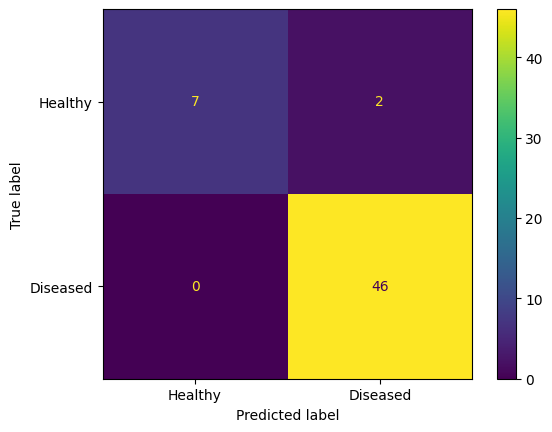

In [77]:
logistic_model, _ = run_ml_model(
    classifier=LogisticRegression(solver='liblinear', random_state=0),
    x_train=x_train_top_univariate_selection,
    y_train=y_train,
    x_test=x_test_top_univariate_selection,
    y_test=y_test,
    param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
)

In [78]:
logistic_model.intercept_

array([-0.06950795])

In [83]:
logistic_model.coef_

array([[ 0.26174465,  0.07806197,  0.20386707,  0.08835001, -0.76621423,
         0.07784945, -0.04307296, -0.02433074,  0.23565868,  0.1795495 ]])

In [91]:
logistic_model.predict_proba(x_test_top_univariate_selection)

/Users/thelgis/Documents/source/applied-bioinformatics-thesis/venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


array([[0.11488989, 0.88511011],
       [0.00320808, 0.99679192],
       [0.04018444, 0.95981556],
       [0.01062161, 0.98937839],
       [0.0099435 , 0.9900565 ],
       [0.01299845, 0.98700155],
       [0.02192297, 0.97807703],
       [0.00235369, 0.99764631],
       [0.01998344, 0.98001656],
       [0.04247669, 0.95752331],
       [0.00434718, 0.99565282],
       [0.00514413, 0.99485587],
       [0.01602857, 0.98397143],
       [0.00256874, 0.99743126],
       [0.13023822, 0.86976178],
       [0.00784749, 0.99215251],
       [0.0114148 , 0.9885852 ],
       [0.95422082, 0.04577918],
       [0.00236259, 0.99763741],
       [0.00506337, 0.99493663],
       [0.00217472, 0.99782528],
       [0.00297916, 0.99702084],
       [0.02919743, 0.97080257],
       [0.00886069, 0.99113931],
       [0.01238252, 0.98761748],
       [0.00909329, 0.99090671],
       [0.61903801, 0.38096199],
       [0.00210804, 0.99789196],
       [0.0031039 , 0.9968961 ],
       [0.00771361, 0.99228639],
       [0.

# Decision Tree 

Default Parameters of Base Model: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
Parameters for tuning provided: {'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 4 folds for each of 36 candidates, totalling 144 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
Cross Validation Scores (cv=4): 0.9375,0.967741935483871,0.967741935483871,0.9354838709677419
Cross Val

/Users/thelgis/Documents/source/applied-bioinformatics-thesis/venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


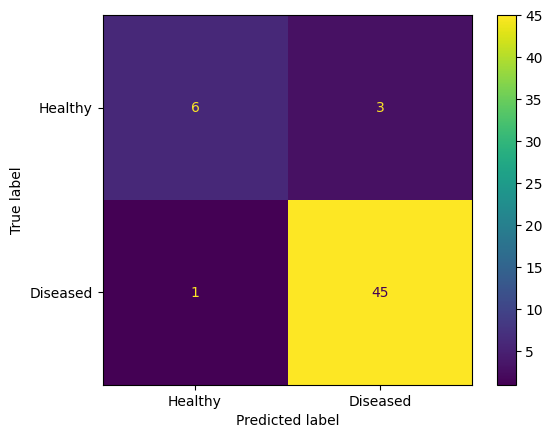

In [85]:
from sklearn import tree

tree_model, _ = run_ml_model(
    classifier=tree.DecisionTreeClassifier(),
    x_train=x_train_top_univariate_selection,
    y_train=y_train,
    x_test=x_test_top_univariate_selection,
    y_test=y_test,
    param_grid={
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
)

[Text(0.5, 0.875, 'x[4] <= 4.54\ngini = 0.258\nsamples = 125\nvalue = [19, 106]'),
 Text(0.25, 0.625, 'x[5] <= 2.865\ngini = 0.019\nsamples = 103\nvalue = [1.0, 102.0]'),
 Text(0.125, 0.375, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.375, 0.375, 'gini = 0.0\nsamples = 102\nvalue = [0, 102]'),
 Text(0.75, 0.625, 'x[2] <= 4.757\ngini = 0.298\nsamples = 22\nvalue = [18, 4]'),
 Text(0.625, 0.375, 'x[1] <= 5.049\ngini = 0.1\nsamples = 19\nvalue = [18, 1]'),
 Text(0.5, 0.125, 'gini = 0.0\nsamples = 18\nvalue = [18, 0]'),
 Text(0.75, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.875, 0.375, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]')]

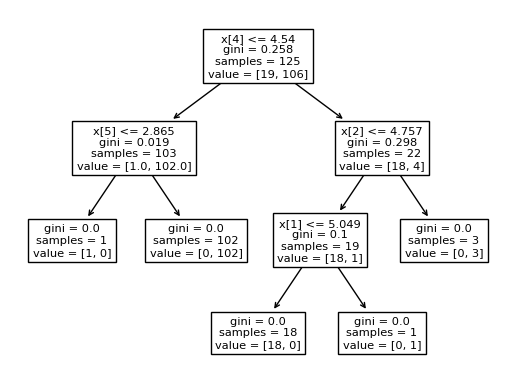

In [86]:
tree.plot_tree(tree_model)

# Gradient boosted Tree

Default Parameters of Base Model: {'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': None, 'max_features': 1.0, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': None, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Parameters for tuning provided: {'max_iter': [100, 1000, 1500], 'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [25, 50, 75], 'l2_regularization': [0.0, 1.5]}
Fitting 4 folds for each of 54 candidates, totalling 216 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 1.5, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': 25, 'max_featu

/Users/thelgis/Documents/source/applied-bioinformatics-thesis/venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


(HistGradientBoostingClassifier(l2_regularization=1.5, max_depth=25,
                                max_iter=1000),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8))

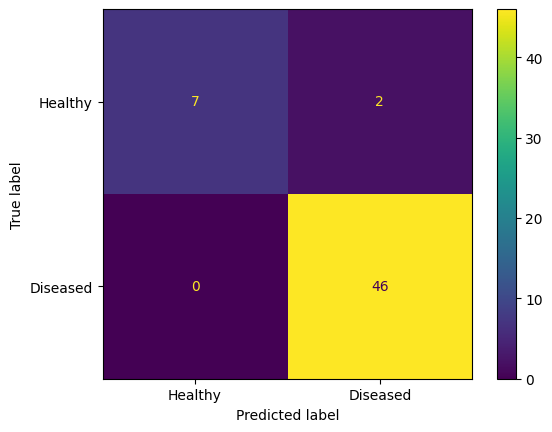

In [87]:
from sklearn.ensemble import HistGradientBoostingClassifier

run_ml_model(
    classifier=HistGradientBoostingClassifier(max_iter=100),
    x_train=x_train_top_univariate_selection,
    y_train=y_train,
    x_test=x_test_top_univariate_selection,
    y_test=y_test,
    param_grid={
        "max_iter": [100, 1000, 1500],
        "learning_rate": [0.1, 0.2, 0.3],
        "max_depth": [25, 50, 75],
        "l2_regularization": [0.0, 1.5]
    }
)

# Random Forest 

Default Parameters of Base Model: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Parameters for tuning provided: {'bootstrap': [True, False], 'max_depth': [10, 50, 100, None], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [10, 100, 1000]}
Fitting 4 folds for each of 216 candidates, totalling 864 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_sa

/Users/thelgis/Documents/source/applied-bioinformatics-thesis/venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


(RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=10),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8))

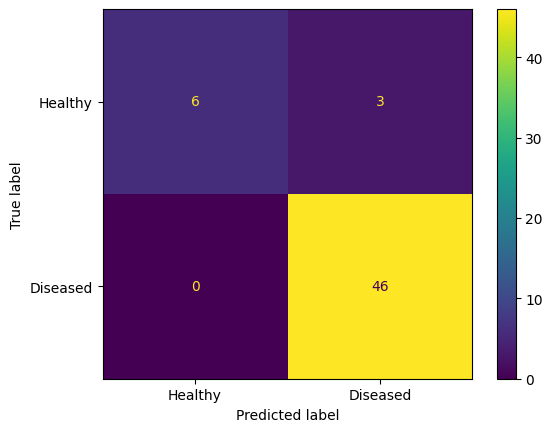

In [88]:
from sklearn.ensemble import RandomForestClassifier

# worst than using the defaults 
run_ml_model(
    classifier=RandomForestClassifier(n_estimators=10),
    x_train=x_train_top_univariate_selection,
    y_train=y_train,
    x_test=x_test_top_univariate_selection,
    y_test=y_test,
    param_grid={
        'bootstrap': [True, False],
        'max_depth': [10, 50, 100, None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [10, 100, 1000]
    }
)

Default Parameters of Base Model: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Running with base model
Cross Validation Scores (cv=4): 0.90625,0.967741935483871,0.9354838709677419,0.967741935483871
Cross Validation gives 0.94 accuracy with a standard deviation of 0.03

Metrics on the Test Set:

        Accuracy: 0.9636363636363636
        Precision: 0.9583333333333334
        Recall: 1.0
        f1: 0.9787234042553191
    


(RandomForestClassifier(n_estimators=10),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8))

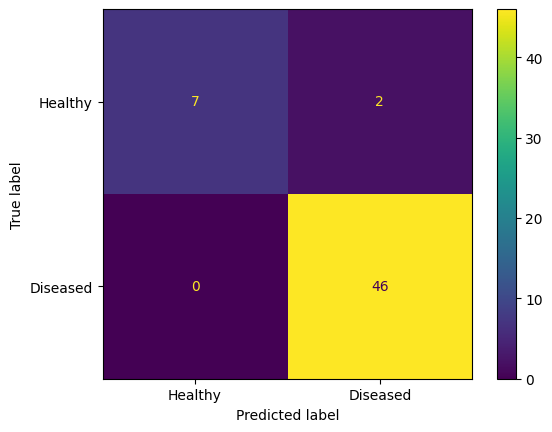

In [89]:
run_ml_model(
    classifier=RandomForestClassifier(n_estimators=10),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

# SVMs

Default Parameters of Base Model: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Parameters for tuning provided: {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Running with hyper-parameter tuned model
Optimised Model Parameters: {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Cross Validation Scores (cv=4): 0.96875,1.0,0.967741935483871,1.0
Cross Validation gives 0.98 accuracy with a standard deviation of 0.02

Metrics on the Test Set:

        Accura

/Users/thelgis/Documents/source/applied-bioinformatics-thesis/venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


(SVC(C=1, gamma=0.1),
 array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8))

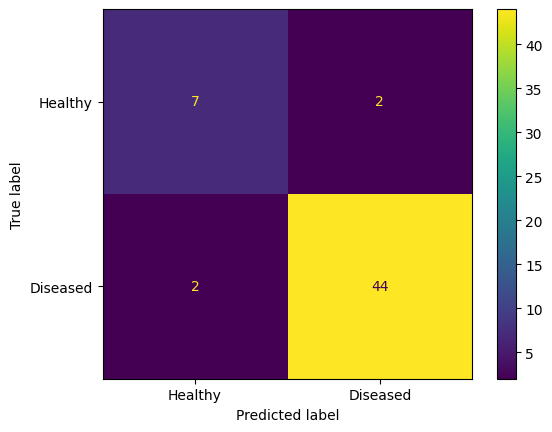

In [90]:
from sklearn import svm

run_ml_model(
    classifier=svm.SVC(),
    x_train=x_train_top_univariate_selection,
    y_train=y_train,
    x_test=x_test_top_univariate_selection,
    y_test=y_test,
    param_grid={
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
    }
)